In [1]:
import numpy as np
import pickle as pkl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from aidam.miscellanea_utils import find_matlabstyle
from scipy.optimize import curve_fit


from aidam.faga.curve_fit import FagaCurveFit

from aidam.math_utils import moving_function_rev1
from aidam.NbEnhance import tabprint

## Lettura dati

In [2]:
data_file='stored_data.pkl'

infile=open(data_file,'rb')
trend=pkl.load(infile)
regioni=pkl.load(infile)
giorni=pkl.load(infile)
giorno_settimana=pkl.load(infile)
infile.close()

day_counter=list(range(len(giorni)))

print('Giorni osservati: %d'%len(giorni))
print('Primo giorno: %s'%giorni[0])
print('Ultimo giorno: %s'%giorni[-1])

Giorni osservati: 122
Primo giorno: 2020-02-24T18:00:00
Ultimo giorno: 2020-06-24T17:00:00


Preparazione date

- creo il giorno 0 nel formato *datetime* per poi creare i nuovi plot su questa base
- creo una lista di giorni (in formato di stringhe) partendo dal giorno0

In [3]:
giorno0=datetime.strptime(giorni[0][0:10], "%Y-%m-%d")
str_giorni=[]
for d in range(500):
    str_giorni.append((giorno0+timedelta(d)).strftime("%Y-%m-%d"))
str_giorni=np.array(str_giorni)

oggi=datetime.strftime(datetime.now(), "%Y-%m-%d")
indice_oggi=find_matlabstyle(str_giorni,lambda x:x==oggi)[0]

## Funzioni base

Si testano due versioni generalizzate della sigmoide:

- sigmoide generalizzata
- sigmoide generalizzata estesa

In [4]:
def generalized_sigmoid(t,a,b,M,alpha):
    y=M/(1+np.exp(-a*t+b))**alpha
    return y

def generalized_sigmoid_ext(t,a,b,c,M,alpha):
    y=(M+c*t)/(1+np.exp(-a*t+b))**alpha
    return y

def double_generalized_sigmoid_ext(t,a1,b1,c1,M1,alpha1,a2,b2,c2,M2,alpha2):
    y=((M1+c1*t)/(1+np.exp(-a1*t+b1))**alpha1)+((M2+c2*t)/(1+np.exp(-a2*t+b2))**alpha2)
    return y

## Fitting

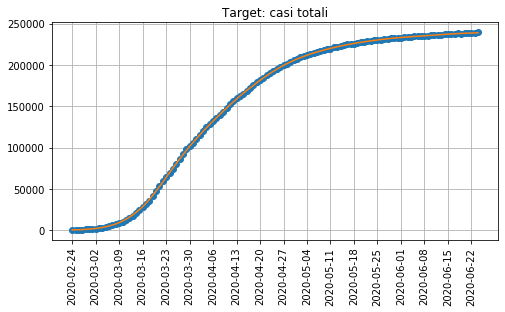

In [5]:
target_data=trend['totale_casi']['Italia']
target_data_filtered=moving_function_rev1(target_data,np.mean,3,3)

fig,ax=plt.subplots(1,1,figsize=(8,4))
ax.plot(day_counter,target_data,'o')
ax.plot(day_counter,target_data_filtered,'-')
ax.set_xticks(list(range(0,len(target_data),7)))
ax.set_title('Target: casi totali')
ax.set_xticklabels(str_giorni[list(range(0,len(target_data),7))],rotation=90)
ax.grid()

## GA-based Curve fitting

E' possibile utilizzare solo **parzialmente** i dati per il tuning del modello: tramite il parametro `days_training` si decide quanti giorni usare effettivamente dall'inizio del dataset


In [6]:
days_training=len(target_data)#-21

# Italia
a_range=[0,0.2]
b_range=[0, 0.1]
c_range=[0,10]
M_range=[2e+5,3e+5]
alpha_range=[0,10]



# dominio per generalized_sigmoid_ext
dominio=np.vstack((a_range,
                   b_range,
                   c_range,
                   M_range,
                   alpha_range))



'''
# dominio per DOUBLE generalized_sigmoid_ext
M_range=[0,3e+5]
dominio=np.vstack((a_range,
                   b_range,
                   c_range,
                   M_range,
                   alpha_range,
                   a_range,
                   b_range,
                   c_range,
                   M_range,
                   alpha_range))
'''
                   
dominio=dominio.T

tabprint(dominio,digits=10,precision=2,index=['Min','Max'])

            0         1         2         3         4
         ----      ----      ----      ----      ----
Min      0.00      0.00      0.00 200000.00      0.00
Max      0.20      0.10     10.00 300000.00     10.00


In [7]:
def error_measure(predicted,actual):
    #return np.mean(np.abs(predicted-actual))+np.std(np.abs(predicted-actual))
    return np.mean(np.abs(predicted-actual))+np.mean(np.abs(predicted[-10:]-actual[-10:]))+np.std(np.abs(predicted-actual))
    #return np.mean(np.abs(predicted-actual)/actual)
    #return 0.4*np.percentile(np.abs(predicted-actual),99)+np.mean(np.abs(predicted-actual))

np.random.seed(42)
    
fct=FagaCurveFit()

fct.fit(generalized_sigmoid_ext, 
        np.arange(days_training),
        target_data[0:days_training],
        dominio,
        ga_generations=1500, ga_population=120,print_info=100,
        error_function=error_measure,
        num_mutations='auto')

print('\nOptimal solution is: ')
solution=fct.opt_params
print(solution)

Welcome to FagaCurveFit!
Gen:     0 BestAll: 2.198 BestGen: 2.198  BioDiv: 6.4e+03
Gen:   100 BestAll: 20.57 BestGen: 20.57  AveFit: 18.81
Gen:   200 BestAll: 20.9 BestGen: 20.9  AveFit: 20.03
Gen:   300 BestAll: 21.16 BestGen: 21.16  AveFit: 19.54
Gen:   400 BestAll: 21.53 BestGen: 21.53  AveFit: 20.1
Gen:   500 BestAll: 21.71 BestGen: 21.71  AveFit: 20.29
Gen:   600 BestAll: 21.98 BestGen: 21.98  AveFit: 20.53
Gen:   700 BestAll: 22.12 BestGen: 22.12  AveFit: 20.03
Gen:   800 BestAll: 22.27 BestGen: 22.27  AveFit: 21.21
Gen:   900 BestAll: 22.28 BestGen: 22.28  AveFit: 20.77
Gen:  1000 BestAll: 22.36 BestGen: 22.36  AveFit: 20.09
Gen:  1100 BestAll: 22.41 BestGen: 22.41  AveFit: 20.93
Gen:  1200 BestAll: 22.54 BestGen: 22.54  AveFit: 20.69
Gen:  1300 BestAll: 22.59 BestGen: 22.59  AveFit: 20.58
Gen:  1400 BestAll: 22.59 BestGen: 22.59  AveFit: 20.71
Gen:  1500 BestAll: 22.59 BestGen: 22.59  AveFit: 20.62

Optimal solution is: 
[6.09944616e-02 2.65794987e-02 9.49959449e+00 2.38692060e

Text(0.5, 0.98, 'Fitness trends')

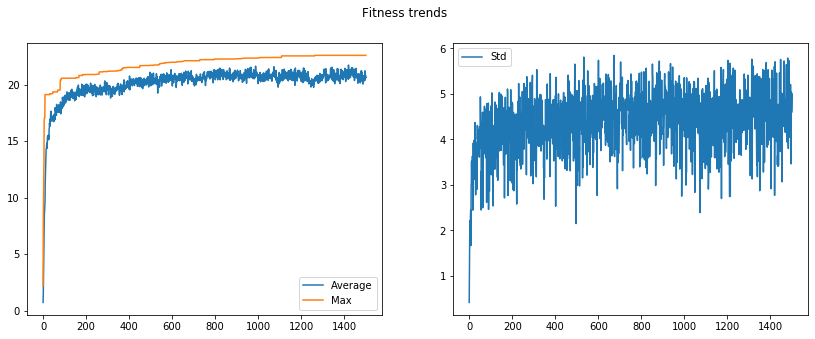

In [8]:
fig,ax=plt.subplots(1,2,figsize=(14,5))
ax[0].plot(fct.fitness_tracker['average'],label='Average')
ax[0].plot(fct.fitness_tracker['max'],label='Max')
ax[0].legend()
ax[1].plot(fct.fitness_tracker['std'],label='Std')
ax[1].legend()
fig.suptitle('Fitness trends')


Adesso applico il modello tunato sia ai giorni passati sia a giorni futuri.

*forecast_days* sono i giorni per cui lo applico: iniziano dal giorno 0 e finoscono quando si vuole nel futuro

In [9]:
forecast_days=np.arange(200)
y_pred=np.array(list(map(lambda x:generalized_sigmoid_ext(x,*solution),forecast_days)))

#### Plots

C:\Users\klaat\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


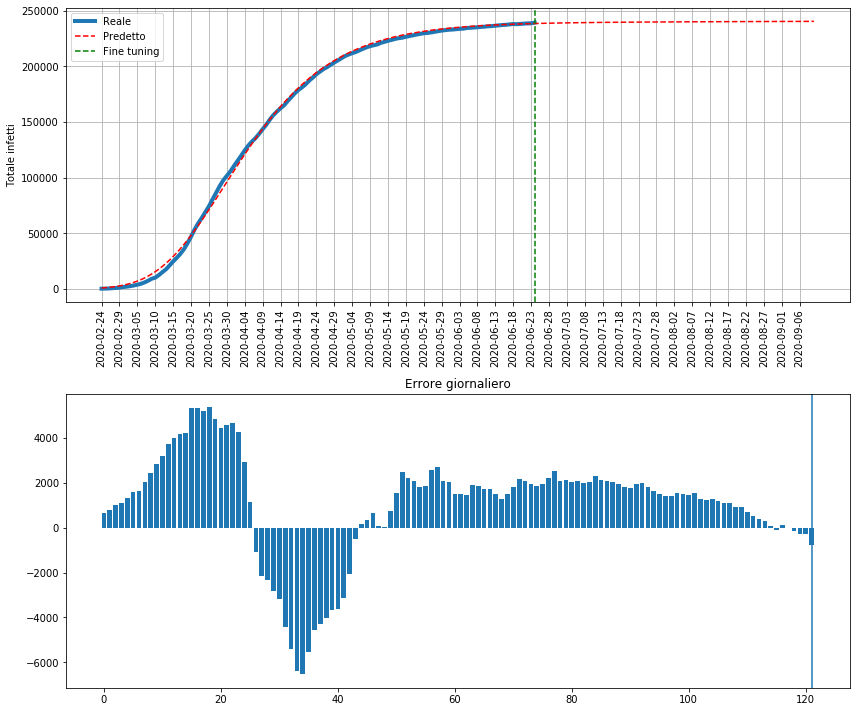

In [10]:
# preparazione palette colori
lista_colori=list(mcolors.TABLEAU_COLORS.items())
color_names=[cn[0] for cn in lista_colori]

fig,ax=plt.subplots(2,1,figsize=(12,10))
ax[0].plot(day_counter,target_data,label='Reale',linewidth=4)
ax[0].plot(forecast_days,y_pred,'r--',label='Predetto')
ax[0].axvline(days_training-1,c='g',ls='--',label='Fine tuning')
ax[0].set_xticks(list(range(0,len(forecast_days),5)))
ax[0].set_xticklabels(str_giorni[list(range(0,len(forecast_days),5))],rotation=90)
ax[0].set_ylabel('Totale infetti')
ax[0].legend()
ax[0].grid()

ax[1].bar(day_counter,y_pred[day_counter]-target_data)
ax[1].axvline(days_training-1)
ax[1].set_title('Errore giornaliero')
fig.tight_layout()
fig.show()

### Adesso vediamo, secondo il modello, quando non avremo più contagiati

In [11]:
nuovi_contagi_pred=np.diff(y_pred)

nuovi_contagi_reali=np.diff(target_data)
nuovi_contagi_reali_filtered=np.diff(target_data_filtered)


soglie_contagi=[1000,500,100,50]
giorni_soglia=[]
for soglia in soglie_contagi:
    nuovi_contagi_sotto_soglia=[i for i,nc in enumerate(nuovi_contagi_pred) if (i>30 and nc<=soglia)]
    giorni_soglia.append(nuovi_contagi_sotto_soglia[0])



In [14]:
nuovi_contagi_reali

array([  93.,   78.,  250.,  238.,  240.,  566.,  342.,  466.,  587.,
        769.,  778., 1247., 1492., 1797.,  977., 2313., 2651., 2547.,
       3497., 3590., 3233., 3526., 4207., 5322., 5986., 6557., 5560.,
       4789., 5249., 5210., 6153., 5959., 5974., 5217., 4050., 4053.,
       4782., 4668., 4585., 4805., 4316., 3599., 3039., 3836., 4204.,
       3951., 4694., 4092., 3153., 2972., 2667., 3786., 3493., 3491.,
       3047., 2256., 2729., 3370., 2646., 3021., 2357., 2324., 1739.,
       2091., 2086., 1872., 1965., 1900., 1389., 1221., 1075., 1444.,
       1401., 1327., 1083.,  802.,  744., 1402.,  888.,  992.,  789.,
        875.,  675.,  451.,  813.,  665.,  642.,  652.,  669.,  531.,
        300.,  397.,  584.,  593.,  516.,  416.,  355.,  178.,  318.,
        321.,  177.,  518.,  270.,  197.,  280.,  283.,  202.,  379.,
        163.,  346.,  338.,  301.,  210.,  328.,  331., -148.,  264.,
        224.,  221.,  113.,  577.])

In [15]:
trend['nuovi_positivi']['Italia']

array([ 221.,   93.,   78.,  250.,  238.,  240.,  566.,  342.,  466.,
        587.,  769.,  778., 1247., 1492., 1797.,  977., 2313., 2651.,
       2547., 3497., 3590., 3233., 3526., 4207., 5322., 5986., 6557.,
       5560., 4789., 5249., 5210., 6153., 5959., 5974., 5217., 4050.,
       4053., 4782., 4668., 4585., 4805., 4316., 3599., 3039., 3836.,
       4204., 3951., 4694., 4092., 3153., 2972., 2667., 3786., 3493.,
       3491., 3047., 2256., 2729., 3370., 2646., 3021., 2357., 2324.,
       1739., 2091., 2086., 1872., 1965., 1900., 1389., 1221., 1075.,
       1444., 1401., 1327., 1083.,  802.,  744., 1402.,  888.,  992.,
        789.,  875.,  675.,  451.,  813.,  665.,  642.,  652.,  669.,
        531.,  300.,  397.,  584.,  593.,  516.,  416.,  355.,  178.,
        318.,  321.,  177.,  518.,  270.,  197.,  280.,  283.,  202.,
        379.,  163.,  346.,  338.,  303.,  210.,  329.,  333.,  251.,
        262.,  224.,  218.,  122.,  190.])

Soglia:  1000   Giorno:   77 [2020-05-11]
Soglia:   500   Giorno:   89 [2020-05-23]
Soglia:   100   Giorno:  118 [2020-06-21]
Soglia:    50   Giorno:  131 [2020-07-04]


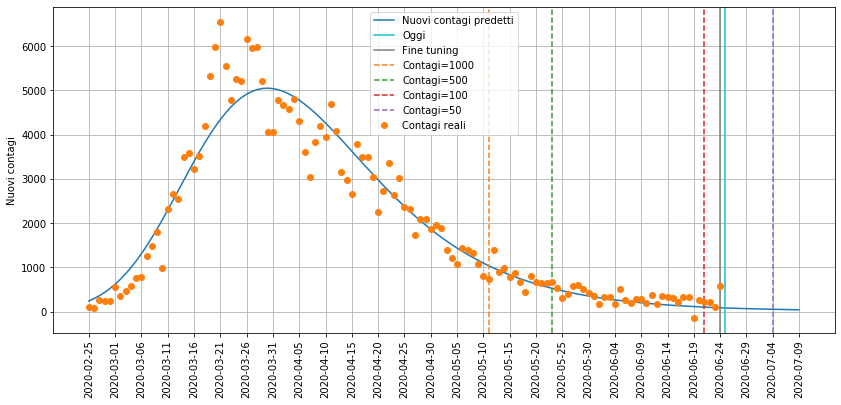

In [12]:
fig,ax=plt.subplots(1,1,figsize=(14,6))
ax.plot(range(max(giorni_soglia)+5),nuovi_contagi_pred[0:max(giorni_soglia)+5],label='Nuovi contagi predetti')
ax.set_ylabel('Nuovi contagi')
ax.axvline(indice_oggi-1,label='Oggi',c=color_names[9])
ax.axvline(days_training-2,label='Fine tuning',c=color_names[7])

for i,soglia in enumerate(soglie_contagi):
    ax.axvline(giorni_soglia[i]-1,label='Contagi=%d'%soglia,c=color_names[i+1],linestyle='--')

ax.plot(nuovi_contagi_reali,'o',label='Contagi reali')
#ax.plot(nuovi_contagi_reali_filtered,'+',label='Contagi reali filt.')
    
ax.set_xticks(list(range(0,max(giorni_soglia)+5,5)))
ax.set_xticklabels(str_giorni[list(range(1,len(forecast_days),5))],rotation=90)
ax.grid()
ax.legend()

for i,soglia in enumerate(soglie_contagi):
    print('Soglia: %5d   Giorno: %4d [%10s]'%(soglia,giorni_soglia[i],str_giorni[giorni_soglia[i]]))

C:\Users\klaat\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\klaat\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


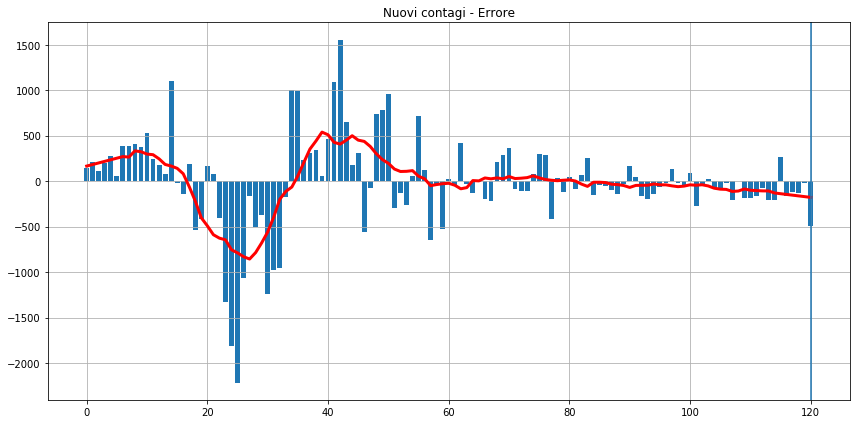

In [13]:
from scipy.signal import savgol_filter


fig,ax=plt.subplots(1,1,figsize=(12,6))
errore_giornaliero=nuovi_contagi_pred[0:len(nuovi_contagi_reali)]-nuovi_contagi_reali
ax.bar(day_counter[0:len(nuovi_contagi_reali)],errore_giornaliero)
#ax.plot(day_counter[0:len(nuovi_contagi_reali)],moving_function_rev1(errore_giornaliero,np.mean,5,2),'r',linewidth=3)
ax.plot(day_counter[0:len(nuovi_contagi_reali)],savgol_filter(errore_giornaliero,13,1),'r',linewidth=3)
ax.axvline(days_training-2)
ax.set_title('Nuovi contagi - Errore')
ax.grid()
fig.tight_layout()
fig.show()